In [58]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn


In [59]:

# Define transformatin for PIL to tensor Format
transformation_operation = transforms.Compose([
    transforms.ToTensor(),             # convert to tensor
])


In [60]:
# Load training and validation datasets
train_dataset = datasets.ImageFolder(root="dataset/train", transform=transformation_operation)
val_dataset = datasets.ImageFolder(root="dataset/valid", transform=transformation_operation)

In [61]:
train_dataset.classes


['Center',
 'Donut',
 'Edge-Loc',
 'Edge-Ring',
 'Local',
 'Near-Full',
 'Normal',
 'Random',
 'Scratch']

In [62]:
image, label = train_dataset[0]
image.shape # [Channel, Height, Width]

torch.Size([3, 640, 640])

In [63]:
# Define Variables
num_classes = 9 #check using train_dataset.classes
batch_size = 64
num_channels = 3 # RGB Color channels
img_size = 640
patch_size = 40 # 640 / 40 = 16 patches per side, 16 × 16 = 256 patches total
num_patches = (img_size // patch_size) **2 # 640/40 = 16 patches
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4 # Number of Transformer Encoder Blocks
mlp_hidden_nodes =  2 * embedding_dim # number of neurons in the hidden layer of the MLP inside each Transformer block, In GPT it is 4*embedding_dim
learning_rate = 0.001
epochs = 5

In [64]:
# Define dataset batches. eg. 64 images at once
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Part1: Patch Embedding - Each Patch is embedded to embedding dimensions, but passed in Batches
# Part2: Transformer Encoder
# Part3: MLP Head
# Part4: Vision Transformer Class

In [65]:
# Sample a data point from train_loader
data_point, label = next(iter(train_loader))

print("Shape of data point: ", data_point.shape) # Batch Size * Number of Channels * Height * Width - [B,C,H,W]
print("Shape of label: ", label.shape) # Batch Size * Number of Channels * Height * Width

patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
# print(patch_embed(data_point))
patch_embed_output = patch_embed(data_point)
print(patch_embed_output.shape)

patch_embed_output_flatten = patch_embed_output.flatten(2)
print("patch_embed_output_flatten: ", patch_embed_output_flatten.shape) # [Batch size, embedding_dim of each patch, 256 patches

# Need to transpose to make [Batch size, No. of Patches in image, embedding_dim of each Patch]
print("patch_embed_output_flatten: ", patch_embed_output_flatten.transpose(1,2).shape)

Shape of data point:  torch.Size([64, 3, 640, 640])
Shape of label:  torch.Size([64])
torch.Size([64, 64, 16, 16])
patch_embed_output_flatten:  torch.Size([64, 64, 256])
patch_embed_output_flatten:  torch.Size([64, 256, 64])


In [66]:

# Part1: Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__() # super() means: "Run the parent class (nn.Module) initializer before continuing here."
        self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size) # Producing Non-overlapping patches using Conv2D without learnable parameters like weights
        
    def forward(self, x):
        # Patch Embedding
        x = self.patch_embed(x)
        # Flattening
        x = x.flatten(2)
        x = x.transpose(1,2)
        
        return x
    
        #[CLASS] Token
        # Position Embedding
            
            
        

In [67]:
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embedding_dim, attention_heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_hidden_nodes),
            nn.GELU(),
            nn.Linear(mlp_hidden_nodes, embedding_dim),
        )
    
    def forward(self, x):
        residual1 = x
        x = self.layer_norm1(x)
        x = self.multihead_attention(x, x, x)[0] # Query, Key, Value, the transformed output is at the index 0
        x = x + residual1
        
        residual2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = x + residual2
        
        return x      
    

In [68]:
# MLP Head
# MLP Head corresponding to the Classification [CLASS] token
class MLP_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.mlp_head = nn.Linear(embedding_dim, num_classes) 
        
    def forward(self, x):
        x = self.layer_norm1(x)
        x = self.mlp_head(x)
        
        return x       

In [69]:
"""
    For CLS Token:
    
    First dimension (1): Batch size → Here, batch size is 1 (only 1 image in the batch).
    Second dimension (1): Sequence length → CLS is just one token, so sequence length is 1
    Third dimension (64): Embedding dimension → Each token (here, the CLS token) is represented by a vector of size 64.

"""

class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        # CLS Token - learnable parameter
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim)) # Number of Token, Number of Channel, Embedding_dim
        # Position embedding - learnable parameter
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim)) # num_patches+1 because there are 256 patches and then one additional cls_token
        self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)]) # 4 Transformer blocks arranged in sequential
        self.mlp_head = MLP_head()
        
        # CLS token passed to MLP head
    def forward(self, x):
        x = self.patch_embedding(x)
        B = x.size(0) # Batch size will be 64 for other bateches but for last it can be less so taking x.size(0)
        class_tokens = self.cls_token.expand(B, -1, -1) # The CLS token is to be present for each batch ie., each image in batch in this case (self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim)))
        x = torch.cat((class_tokens, x), dim=1) # Prepend CLS token to the patches, dim=1 will be 0th token for CLS and remaining will be patches
        x = x + self.position_embedding
        x = self.transformer_blocks(x)
        x = x[:,0] # getting only the CLS token to be passed next to MLP head for classification
        x = self.mlp_head(x)
        
        return x

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [71]:
# Training

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\n Epoch {epoch+1}")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)
        correct_epoch += correct
        total_epoch += labels.size(0)
        
        if batch_idx % 100 ==0:
            print(f"Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")
            
    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")
        
        
        
        
    


 Epoch 1
Batch   1: Loss = 2.2216, Accuracy = 14.06%
==> Epoch 1 Summary: Total Loss = 132.8787, Accuracy = 45.19%

 Epoch 2
Batch   1: Loss = 0.6437, Accuracy = 84.38%
==> Epoch 2 Summary: Total Loss = 47.9275, Accuracy = 80.97%

 Epoch 3
Batch   1: Loss = 0.2969, Accuracy = 92.19%
==> Epoch 3 Summary: Total Loss = 36.2434, Accuracy = 84.95%

 Epoch 4
Batch   1: Loss = 0.3644, Accuracy = 89.06%
==> Epoch 4 Summary: Total Loss = 31.7184, Accuracy = 86.61%

 Epoch 5
Batch   1: Loss = 0.3934, Accuracy = 87.50%
==> Epoch 5 Summary: Total Loss = 27.1993, Accuracy = 88.46%


In [72]:
# Vision Transformer Class - Switch to evaluation mode
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 88.92%


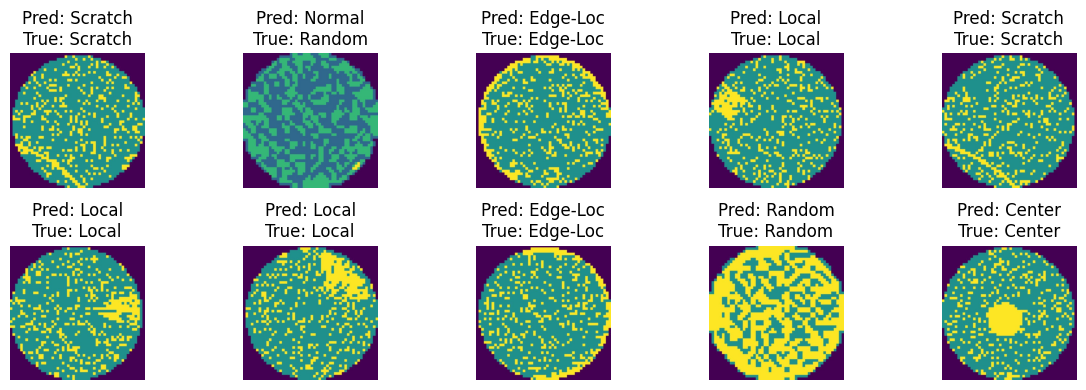

In [76]:
import matplotlib.pyplot as plt

# Use this if using ImageFolder
class_names = train_dataset.classes

model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)

    img = images[i].permute(1, 2, 0)

    plt.imshow(img)
    pred_name = class_names[preds[i].item()]
    true_name = class_names[labels[i].item()]

    plt.title(f"Pred: {pred_name}\nTrue: {true_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()
